In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, precision_recall_curve,confusion_matrix,auc,roc_auc_score,RocCurveDisplay, roc_curve,PrecisionRecallDisplay

## Data loading

In [2]:
df = pd.read_csv('fake_news.csv')

About the Dataset:

1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks whether the news article is real or fake:
           1: Fake news
           0: real News





In [3]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


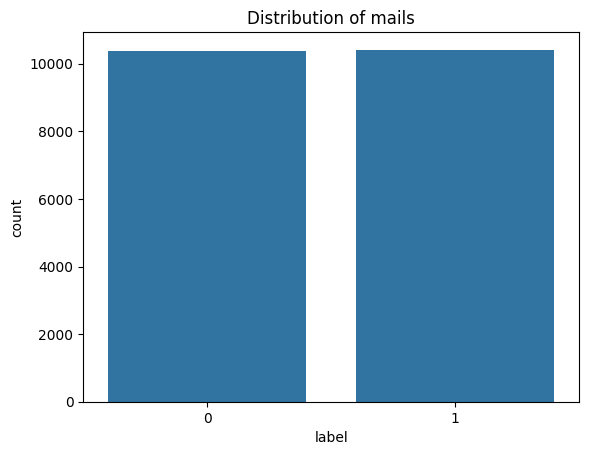

In [4]:
sns.countplot(data=df, x='label')
plt.xlabel('label')
plt.ylabel('count')
plt.title('Distribution of mails')
plt.show()

#### dataset is unbalanced

In [5]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

#### drop raws with empty 'text' column:

In [6]:
df = df[df['text'].notna()]

#### replace the null values with empty string

In [7]:
df = df.fillna(' ')

#### merging  author name and title

In [8]:
df['content'] = df['author'] + ' ' + df['title']

In [9]:
df

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,"Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma..."
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,Michael J. de la Merced and Rachel Abrams Macy...
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,"Alex Ansary NATO, Russia To Hold Parallel Exer..."


#### drop extra columns:

In [10]:
df = df.drop(['id','title','author'], axis=1)

## Stemming

#### reducing a word to its root word

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def stemming(content):
    port_stem = PorterStemmer()
    # remove all values except letters from the content: 
    stemmed_content = re.sub('[^a-zA-Z]',' ',content) 
    # replace capital letter by lower case:
    stemmed_content = stemmed_content.lower() 
    # convert content to list:
    stemmed_content = stemmed_content.split() 
    # replaces content by root word:
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    # from list to string:
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [13]:
df['content'] = df['content'].apply(stemming)

In [14]:
df

,text,label,content
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,darrel lucu hous dem aid even see comey letter...
1,Ever get the feeling your life circles the rou...,0,daniel j flynn flynn hillari clinton big woman...
2,"Why the Truth Might Get You Fired October 29, ...",1,consortiumnew com truth might get fire
3,Videos 15 Civilians Killed In Single US Airstr...,1,jessica purkiss civilian kill singl us airstri...
4,Print \nAn Iranian woman has been sentenced to...,1,howard portnoy iranian woman jail fiction unpu...
...,...,...,...
20795,Rapper T. I. unloaded on black celebrities who...,0,jerom hudson rapper trump poster child white s...
20796,When the Green Bay Packers lost to the Washing...,0,benjamin hoffman n f l playoff schedul matchup...
20797,The Macy’s of today grew from the union of sev...,0,michael j de la merc rachel abram maci said re...
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",1,alex ansari nato russia hold parallel exercis ...


## Split into features and target

In [15]:
X = df['content']
Y = df['label']

## Converting the textual data to numerical

In [16]:
vectorizer = TfidfVectorizer()

In [17]:
X = vectorizer.fit_transform(X)

In [18]:
X.shape

(20761, 16967)

## Split data into train and test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

In [20]:
def print_metrix(y_test,y_pred):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    #print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))    

## Model building - Logistic Regression

In [21]:
model = LogisticRegression()

In [22]:
model.fit(X_train, y_train)

LogisticRegression()

In [23]:
y_pred = model.predict(X_test)

In [24]:
print_metrix(y_test,y_pred)

test-set confusion matrix:
 [[2005   73]
 [  21 2054]]
recall score:  0.9898795180722891
precision score:  0.9656793606017866
f1 score:  0.9776297001427892
accuracy score:  0.9773657596917891
